# Analyse results from Pypsa-Earth
This notebook reads the latest optimization described in the config.yaml file and makes plots and summaries of the results.

Sources: 
- Plot capacity - map view: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/viz/regional_transm_system_viz.ipynb
- Analyse energy potential: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/build_renewable_profiles.ipynb
- Analyse energy generation: https://pypsa.readthedocs.io/en/latest/examples/statistics.html

Some files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may be found in "resources/shapes/country_shapes.geojson")
* a renewable profile file (may be found in "resources/renewable_profiles/....nc)

## Import packages

In [1]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning: The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 
  warnings.warn(


In [2]:
# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

In [3]:
!pwd

/Users/gbotemi/Documents/code/PYPSA/africa-master-plan


## Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [4]:
PARENT = os.path.realpath("pypsa-earth/") + "/"
config = yaml.safe_load(open(PARENT + "config.yaml"))

# Read config.yaml settings:
name = config["run"]["name"]
simpl = config["scenario"]["simpl"]
clusters = config["scenario"]["clusters"]
ll = config["scenario"]["ll"]
opts = config["scenario"]["opts"]

# Ensure elements are strings and properly joined
simpl_str = "_".join(map(str, simpl))
clusters_str = "_".join(map(str, clusters))
ll_str = "_".join(map(str, ll))
opts_str = "_".join(map(str, opts))

nc_file_name = f"elec_s{simpl_str}_{clusters_str}_ec_l{ll_str}_{opts_str}.nc"
scenario_name = name 
scenario_subpath = scenario_name + "/" if scenario_name else ""

# Network file
results_path = PARENT + f"results/{scenario_subpath}networks/{nc_file_name}"
network_path = PARENT + f"networks/{scenario_subpath}elec.nc"
# Country shape file
regions_onshore_path = PARENT + f"resources/{scenario_subpath}shapes/country_shapes.geojson"
# Renewable profile file
solar_path = PARENT + f"resources/{scenario_subpath}renewable_profiles/profile_solar.nc"
onwind_path = PARENT + f"resources/{scenario_subpath}renewable_profiles/profile_onwind.nc"

## Energy system analysis setup - power and energy generation

In [5]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# n = pypsa.Network(results_path)
n = pypsa.Network("pypsa-earth/results/eeap/networks/elec_s_30_ec_lcopt_Co2L-24H.nc")
regions_onshore = gpd.read_file(regions_onshore_path)
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
warnings.simplefilter(action='default', category=FutureWarning)

INFO:pypsa.io:Imported network elec_s_30_ec_lcopt_Co2L-24H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Data import check

Plot of the region of interest

Text(0.5, 1.0, 'ET, BI, CD, UG, KE, SO, RW, EG, SS, LY, SD, TZ, DJ')

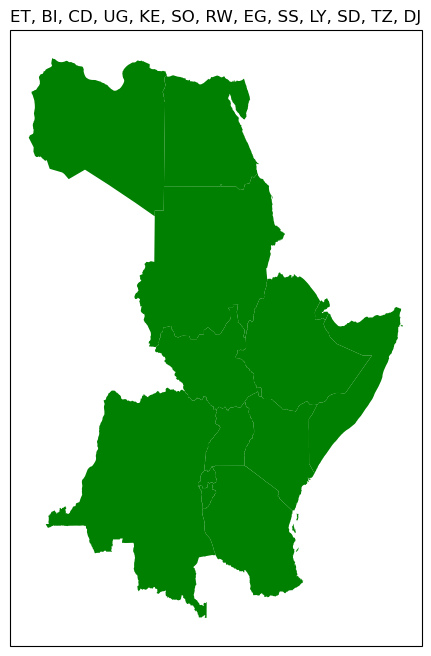

In [6]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
with plt.rc_context({"patch.linewidth": 0.}):
    regions_onshore.plot(
    ax=ax,
    facecolor="green",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
    )
ax.set_title(", ".join(regions_onshore.name.values))

List number of components by type

In [7]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 120 entries
Component 'Carrier' has 19 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 29 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 154 entries
Component 'Load' has 30 entries
Component 'Generator' has 198 entries
Component 'StorageUnit' has 10 entries
Component 'Store' has 90 entries


List the snapshots of the PyPSA network

In [8]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='snapshot', length=365, freq=None)
Time steps: 365


## Analyse energy system

Analyse the current capacity of the energy system - map view

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


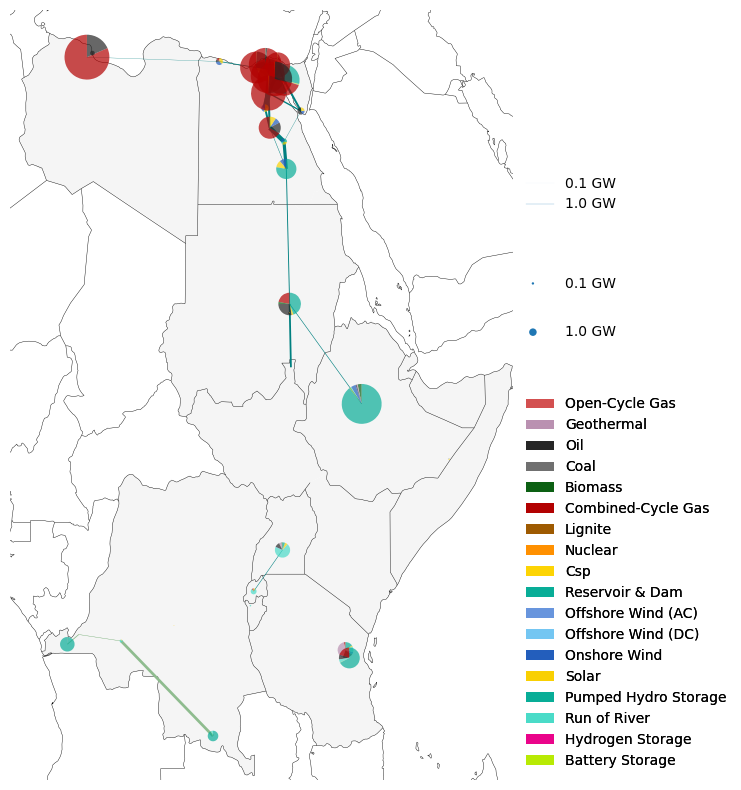

In [9]:
# Scale settings
bus_scale = 6e3 
line_scale = 6e3

# Legend settings
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

n.carriers.drop("Load", inplace=True)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analyse the current generation capacity of the energy system - pie chart view

In [10]:
# generator_capacity_by_carrier.plot(kind="bar", stacked=True, figsize=(10, 5), color=n.carriers.color,)

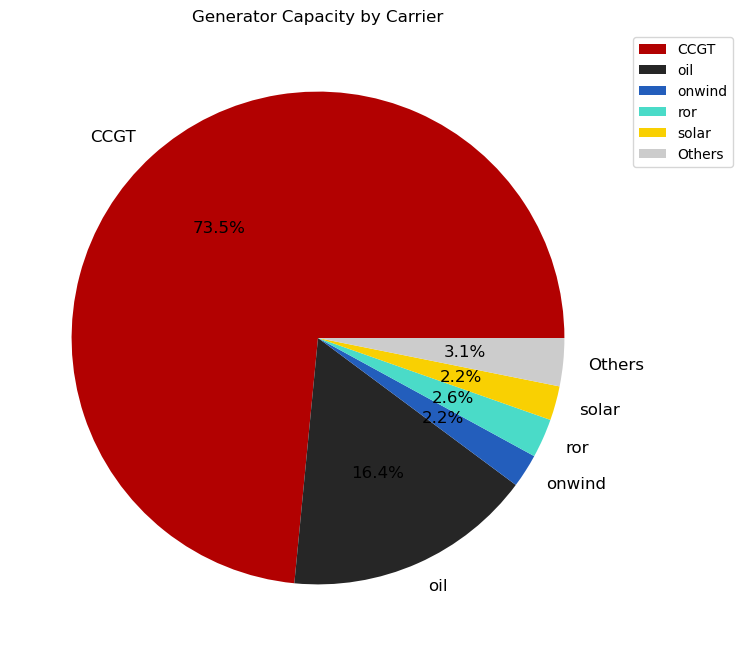

In [11]:
generator_capacity_by_carrier = (
    n.generators[n.generators.carrier != "load"]
    .groupby(["carrier"])
    .p_nom.sum()
)
total_capacity = generator_capacity_by_carrier.sum()
threshold = 0.02 * total_capacity

below_threshold = generator_capacity_by_carrier[generator_capacity_by_carrier < threshold]
above_threshold = generator_capacity_by_carrier[generator_capacity_by_carrier >= threshold]
others_capacity = below_threshold.sum()

if others_capacity > 0:
    above_threshold['Others'] = others_capacity

colors = n.carriers[
            n.carriers.index.isin(above_threshold.index)
        ].color.reindex(above_threshold.index).fillna('#cccccc')

plt.figure(figsize=(8, 8))
plt.pie(
    above_threshold,
    labels=above_threshold.index,
    autopct='%1.1f%%',
    colors=colors,
    textprops={'fontsize': 12}
)
plt.title("Generator Capacity by Carrier")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

Analyse the current gernation capacity of the energy system - tabular view

In [12]:
generator_capacity_by_carrier/1e3 # in GW

carrier
CCGT          67.689237
biomass        0.614000
csp            0.000000
geothermal     1.092000
nuclear        1.194000
offwind-ac     0.000000
offwind-dc     0.000000
oil           15.075443
onwind         2.036615
ror            2.364614
solar          2.067946
Name: p_nom, dtype: float64

Analyse the future capacity of the energy system - map view

/Users/gbotemi/miniconda3/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


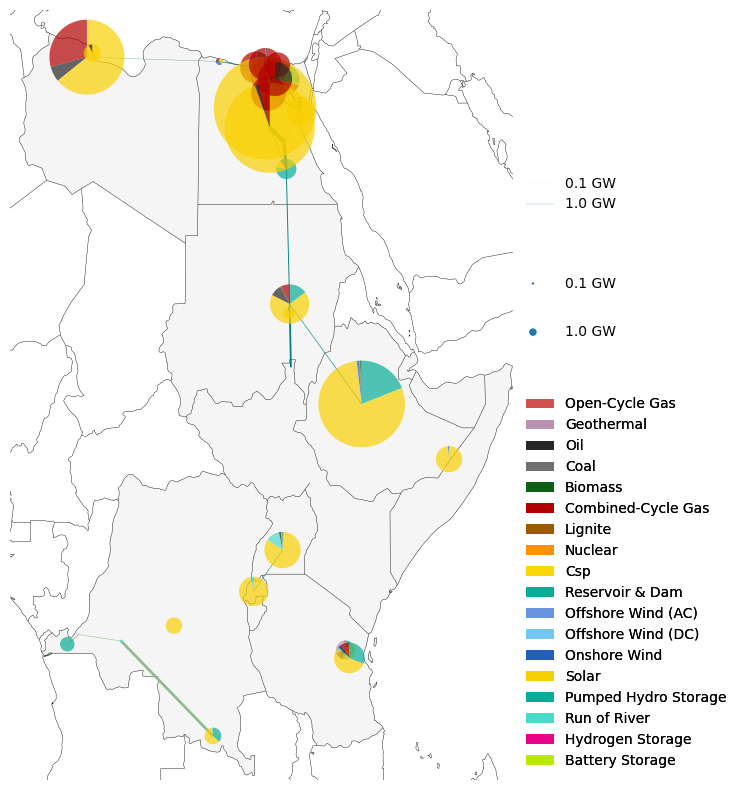

In [13]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[n.generators.carrier != "load"].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analys the future generation capacity expansion of the energy system - bar chart

<AxesSubplot:title={'center':'Generator capacity expansion in GW'}, xlabel='carrier'>

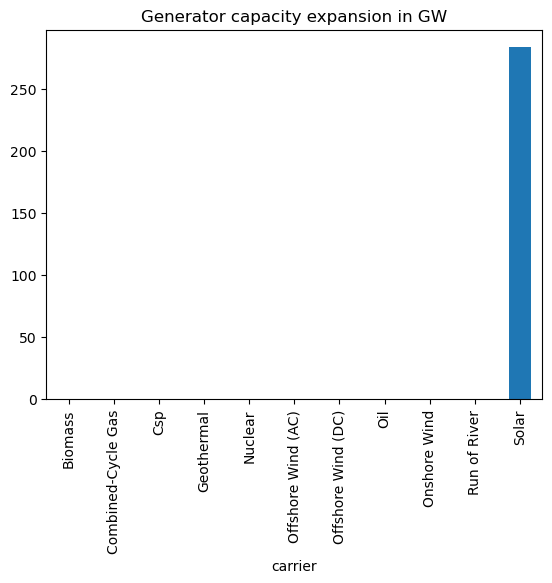

In [14]:
optimal_capacity = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)
installed_capacity = n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)
generation_capacity_expansion = optimal_capacity - installed_capacity
generation_capacity_expansion.drop(["load"], inplace=True)
generation_capacity_expansion.plot.bar(title="Generator capacity expansion in GW")

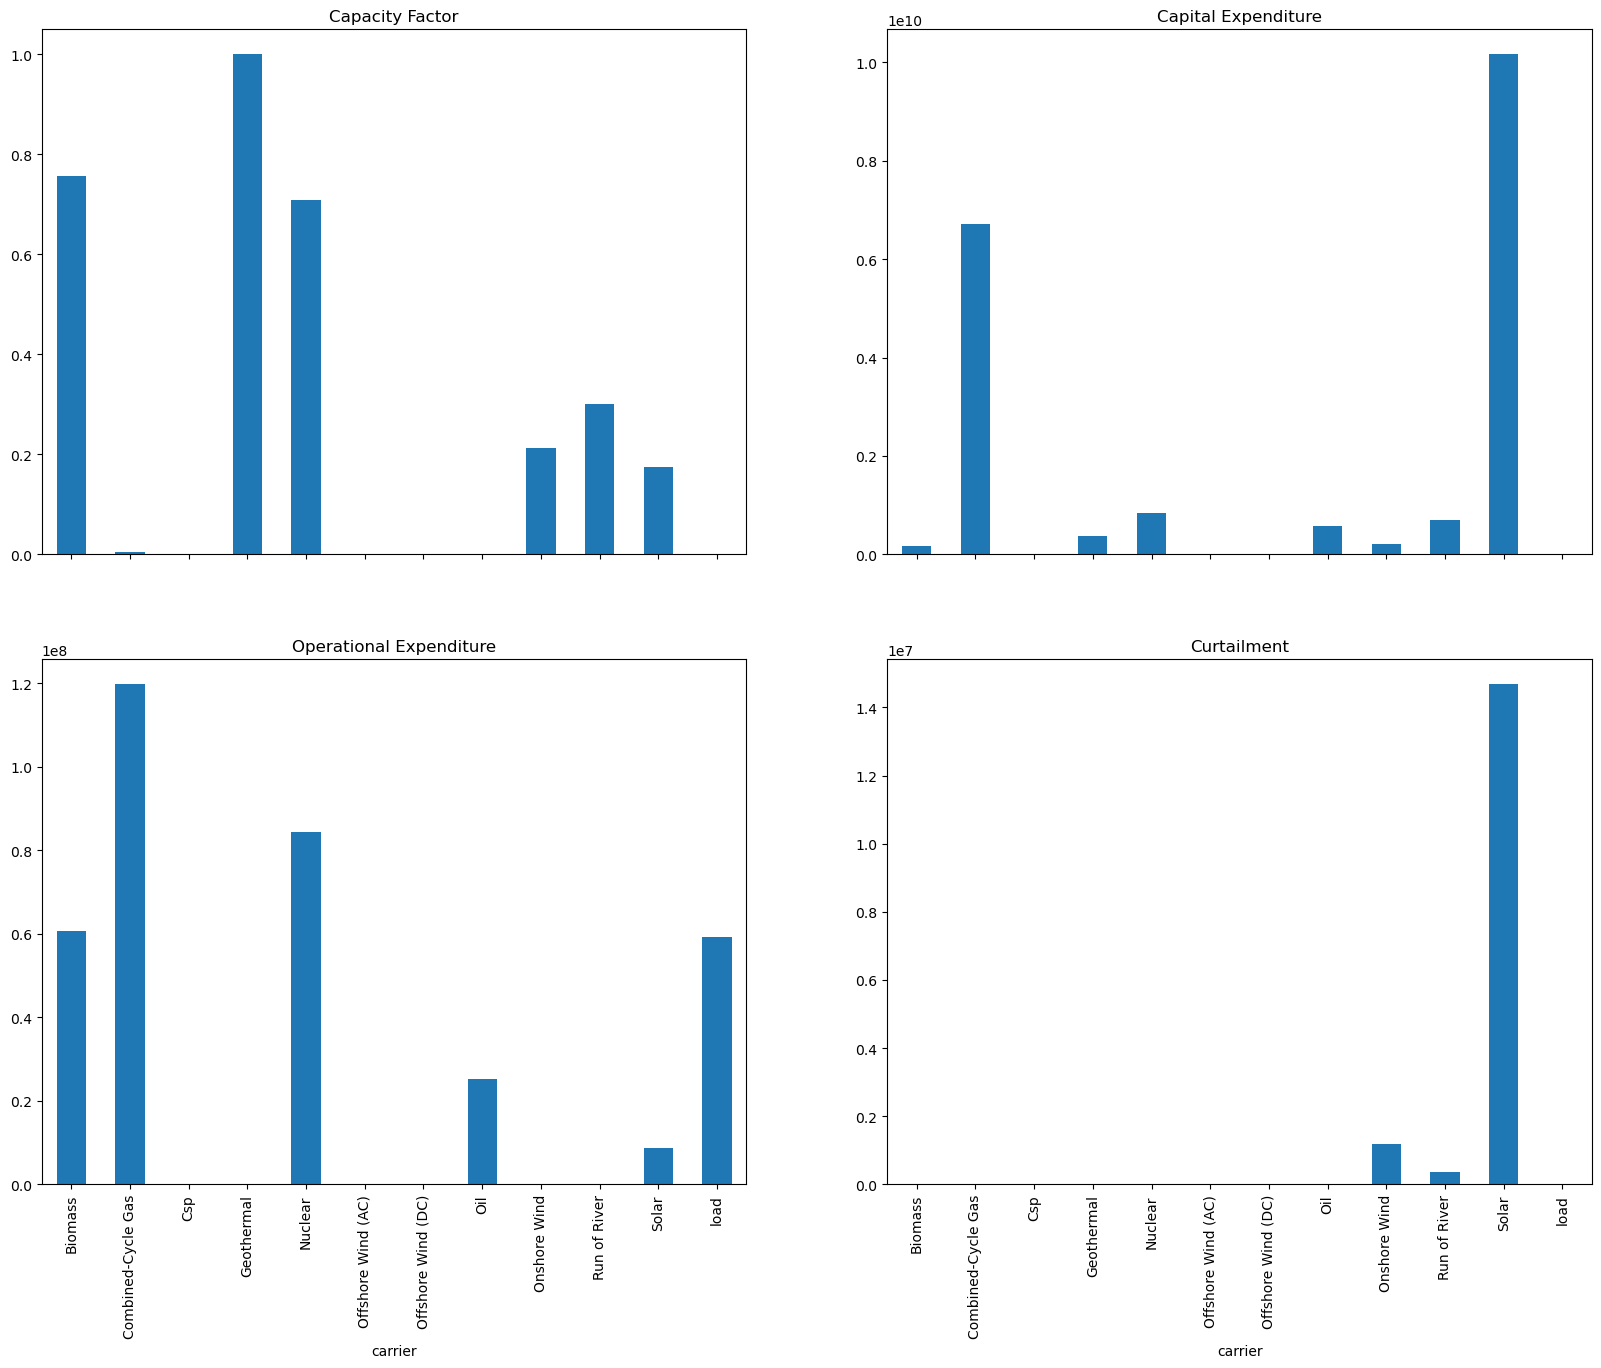

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharex=True)
gen_data = n.statistics().T["Generator"].T[["Capacity Factor", "Capital Expenditure", "Operational Expenditure", "Curtailment"]]
for idx in range(len(gen_data.columns)):
	gen_data[f"{gen_data.columns[idx]}"].plot.bar(title=f"{str(gen_data.columns[idx])}", ax=axes.flatten()[idx])

plt.show()

Plot the future generation capacity expansion of the energy system - tabular chart

In [16]:
generation_capacity_expansion # In GW

carrier
Biomass                 0.000000
Combined-Cycle Gas      0.000000
Csp                     0.000000
Geothermal              0.000000
Nuclear                 0.000000
Offshore Wind (AC)      0.000000
Offshore Wind (DC)      0.000000
Oil                     0.000000
Onshore Wind            0.084757
Run of River            0.000000
Solar                 283.330458
dtype: float64

Analyse the future energy generation of the energy system - bar chart view

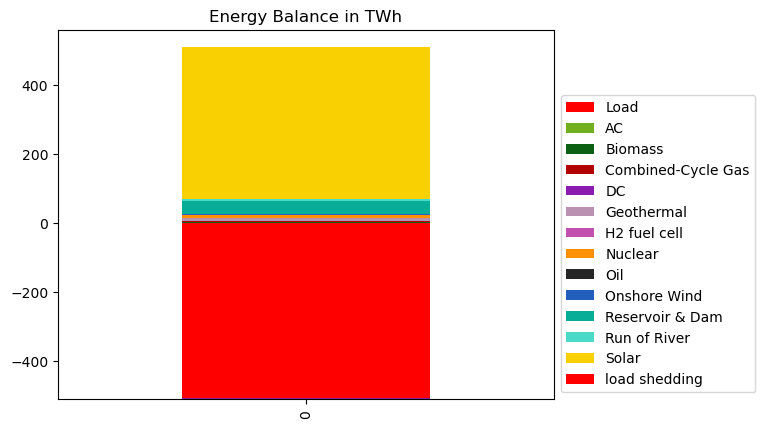

In [17]:
colors = {key.lower(): value.lower() for key, value in config["plotting"]["tech_colors"].items()}
nice_names = {value.lower(): key for key, value in config["plotting"]["nice_names"].items()}

rename_cols = {
    '-': 'Load',
    'load': 'load shedding',
}

energy_balance = (
    n.statistics.energy_balance()
    .loc[:, :, "AC"]
    .groupby("carrier")
    .sum()
    .div(1e6)
    .to_frame()
    .T
    .rename(columns=rename_cols)
)

energy_balance = energy_balance.T[energy_balance.T[0] != 0].T

# color-matching
color_list = []
for col in energy_balance.columns:
    original_name = col.lower()
    key_name = nice_names.get(original_name, original_name)
    color = colors.get(key_name.lower(), 'gray')
    color_list.append(color)


fig, ax = plt.subplots()
energy_balance.plot.bar(stacked=True, ax=ax, title="Energy Balance in TWh", color=color_list)
handles, labels = ax.get_legend_handles_labels()
nice_labels = [config["plotting"]["nice_names"].get(label, label) for label in energy_balance.columns]
ax.legend(handles, nice_labels, bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

plt.show()

Analyse the future energy generation of the energy system - tabular view

In [18]:
n.statistics.energy_balance()/1e6 # In TWh

             carrier               bus_carrier
Load         -                     AC            -5.068812e+02
                                   DC            -3.273805e+00
Line         AC                    AC            -6.053597e-15
StorageUnit  Pumped Hydro Storage  AC             0.000000e+00
             Reservoir & Dam       AC             3.701307e+01
Generator    Biomass               AC             4.071441e+00
             Combined-Cycle Gas    AC             3.080740e+00
             Csp                   csp            0.000000e+00
             Geothermal            AC             9.565920e+00
             Nuclear               AC             7.406788e+00
             Offshore Wind (AC)    AC             0.000000e+00
             Offshore Wind (DC)    AC             0.000000e+00
             Oil                   AC             1.688447e-01
             Onshore Wind          AC             3.953890e+00
                                   DC             0.000000e+00
        

## Analyse pv and wind potential - map view

In [19]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"{PARENT}resources/{scenario_name}/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

Plot wind energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


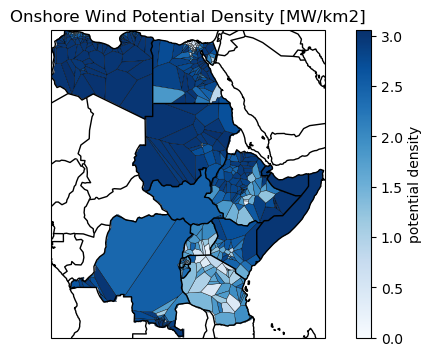

In [20]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Plot pv energy potential

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, loads, storage_units, transformers


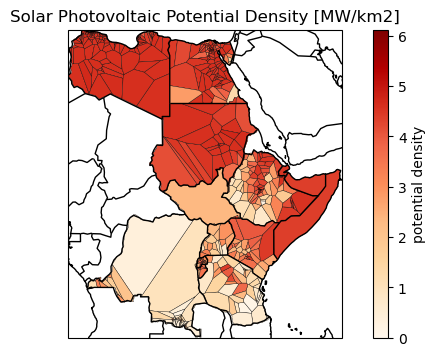

In [21]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)